In [10]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
import shutil
import getpass
import yaml

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pd.options.display.width = 132
pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
 
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print(' Timestamp: ','./tmp/sql_cohort'+'_'+timestamp+'.txt')
# logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
# FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
# logging.basicConfig(level="INFO", format= FORMAT)

insert ./src
insert ../..
2.2.1+cu118
 Timestamp:  ./tmp/sql_cohort_2024_05_06_11:58:05.txt


In [3]:
from snnl.utils import parse_args, get_hyperparameters, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_train_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary

from dev_base import Model
from dev_dnn import DNN 
from dev_autoencoder import Autoencoder
from dev_snnloss import SNNLoss

In [174]:
import sklearn.metrics as skm 
import scipy.stats as sps 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sb

In [18]:
import wandb
os.environ["WANDB_NOTEBOOK_NAME"] = "./DNN_dev.ipynb"
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace

# Setup

In [4]:
current_device = get_device()
print(f"Current device is : {current_device}")

 device: 0   Quadro GV100                   :  free: 31,668,633,600 B   (29.49 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 30,070,603,776 B   (28.01 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 2   NVIDIA TITAN Xp                :  free: 12,464,029,696 B   (11.61 GB)    total: 12,774,539,264 B   (11.90 GB)
 Current CUDA Device is: cuda:0 Quadro GV100 0
Current device is : cuda:0


In [5]:
current_device = set_device(2)

 Running on: Quadro GV100 0
 Switch to cuda:2 
 Running on: NVIDIA TITAN Xp 2


#### main(args)

In [12]:
# if __name__ == "__main__":
input_args = f" --seed              1234 " \
             f" --model             snnl" \
             f" --configuration      hyperparameters/autoencoder_cellpainting.yaml"
             # f" --configuration    hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())
args

with open(args.configuration) as f:
    args = types.SimpleNamespace(**yaml.safe_load(f), **(vars(args)))
args.batch_size = args.cellpainting_args['batch_size']
args.compounds_per_batch = args.cellpainting_args['compounds_per_batch']

set_global_seed(args.seed)
# ## Autoencoder
# (   dataset,
#     batch_size,
#     epochs,
#     learning_rate,
#     input_shape,
#     code_units,
#     units,
#     activations,
#     snnl_factor,
#     temperature,
#     cellpainting_args
# ) = get_hyperparameters(args.configuration)

Namespace(seed=1234, model='snnl', configuration='hyperparameters/autoencoder_cellpainting.yaml')

In [15]:
trn_file_sz = args.cellpainting_args['train_end'] - args.cellpainting_args['train_start']
val_file_sz = args.cellpainting_args['val_end']   - args.cellpainting_args['val_start']
tst_file_sz = args.cellpainting_args['test_end']  - args.cellpainting_args['test_start']
smp_sz = args.cellpainting_args['sample_size']
buf_sz = args.cellpainting_args['compounds_per_batch']
bth_sz = args.batch_size
recs_per_batch = smp_sz * bth_sz * buf_sz

for file_sz in [tst_file_sz]:
    bth_per_epoch = file_sz // recs_per_batch
    print(f" - Each mini-batch contains {recs_per_batch/smp_sz} compounds with {smp_sz} samples per each compound : total {recs_per_batch} rows")
    print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
    print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
    print(f" - Last partial batch contains : {file_sz % recs_per_batch} rows")
    print() 

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 12
 - Rows covered by 12 full size batches (300 rows) per epoch:  3600
 - Last partial batch contains : 0 rows



In [16]:
# args.project_name = 'CellPainting_Profiles'
# args.exp_id   = None
# args.exp_name = datetime.now().strftime('%m%d_%H%M')
# args.exp_desc = 'Autoencoder Training in SNNL mode'

# wandb_run = init_wandb(args)

In [19]:
list_namespace(args)


command line parms : 
-----------------------
activations..............  ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  100
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_start................  0
    validation_path..........  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv

code_units...............  50
compounds_per_batch...

### Load Cell Painting Dataset

In [20]:
   #### Load CellPainting Dataset
if args.dataset == 'cellpainting':
    print(f" load {args.dataset}")
    test_dataset = CellpaintingDataset(type = 'test',    **args.cellpainting_args)
    test_loader = InfiniteDataLoader(dataset=test_dataset, batch_size= args.batch_size,shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

 load cellpainting
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    _init()_    -- type :             test
    _init()_    -- start :            30000
    _init()_    -- end :              33600
    _init()_    -- numrows :          3600


# Define Autoencoder Model

In [102]:
# input_shape = 784
# code_units =  20
args.temperature   = 0.00
args.loss_factor   = 1.0
args.snnl_factor   = 1.0e+00
args.learning_rate = 1.0e-04    ## 0.001
args.temperatureLR = 1.0e-02    ## 1e-4
# temperatureLR = 1e-03     ## 1e-4
print(f"   Units             {args.units}")
print(f"   Activations       {args.activations}")
print(f"   Latent dim        {args.code_units}")
print(f"   loss_factor       {args.loss_factor}")
print(f"   snnl_factor       {args.snnl_factor}")
print(f"   temperature       {args.temperature}")
print(f"   learning_rate     {args.learning_rate}")
print(f"   temperatureLR:    {args.temperatureLR}")

   Units             [['linear', 1471, 1024], ['relu', 0, 0], ['linear', 1024, 128], ['relu', 0, 0], ['linear', 128, 50], ['linear', 50, 128], ['relu', 0, 0], ['linear', 128, 1024], ['relu', 0, 0], ['linear', 1024, 1471]]
   Activations       ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
   Latent dim        50
   loss_factor       1.0
   snnl_factor       1.0
   temperature       0.0
   learning_rate     0.0001
   temperatureLR:    0.01


In [136]:
del model
if args.model.lower() == "baseline":
    print(f"Defining model in baseline mode")
    model = Autoencoder(
        units       = args.units,
        activations = args.activations,
        code_units  = args.code_units, 
        criterion   = torch.nn.MSELoss(reduction='mean'),
        input_shape = args.input_shape, 
        sample_size = args.cellpainting_args['sample_size'],
        loss_factor = args.loss_factor,
        snnl_factor = args.snnl_factor,
        learning_rate=args.learning_rate,
        embedding_layer = 4,
        use_scheduler = True
        )
elif args.model.lower() == "snnl":
    print(f"Defining model in SNNL mode ")
    model = Autoencoder(
        mode="latent_code",
        units=args.units,
        activations = args.activations,
        code_units  = args.code_units,
        input_shape = args.input_shape,
        sample_size = args.cellpainting_args['sample_size'],
        criterion   = torch.nn.MSELoss(reduction='mean'),
        loss_factor = args.loss_factor,
        learning_rate=args.learning_rate,
        use_snnl    = True,
        snnl_factor = args.snnl_factor,
        temperature = args.temperature,
        use_annealing= False,        
        use_sum = False,
        temperatureLR = args.temperatureLR,
        adam_weight_decay = 0,
        SGD_weight_decay = 0,
        embedding_layer = 4,
        use_scheduler = True
        )
else:
    raise ValueError("Choose between [baseline] and [snnl] only.")

model.device

Defining model in SNNL mode 

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- unsupervised :     None
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      0.0
    Model_init()_    -- temperature LR:    0.01
 for latent_code support for unsupervised is True

------------------------------------------------------------
 Build SNNLoss from NOTEBOOK
------------------------------------------------------------
    SNNLoss _init()_    -- mode: latent_code was found in SNNLoss._supported_modes --   is unsupervised: True
    SNNLoss _init()_    -- unsupervised :     True
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      3
    SNNLoss _init()_    -- temperature :      0.0



/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


device(type='cuda', index=0)

#### Display model summary

In [137]:
# display_model_summary(model)

# Load Model

In [229]:
epochs = 200
timestamp = "20240506"
snnl_factor=model.snnl_factor
title="autoencoder"
# title='Xentropy'
# title="dnnconfig03"
# filename = f"AE_{args.model.lower()}_{date}_{title}_{epochs:03d}_cpb_{args.compounds_per_batch}_factor_{factor}.pt"
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs:03d}_cpb_{args.compounds_per_batch}_factor_{factor:d}.pt"
filename = os.path.join('ckpts', filename)
print(filename)
if os.path.exists(filename):
    print(f"\n *** Checkpoint EXISTS *** \n")
    model, last_epoch = load_checkpoint(model, filename)
    model.eval()
    # model = model.to(current_device)
    # model.to('cpu')
    model.device
    model.temperature
else:
    print(f"\n *** Checkpoint DOESNT EXISTS *** \n")

ckpts/AE_snnl_20240506_autoencoder_200_cpb_100_factor_1.pt

 *** Checkpoint EXISTS *** 

(<class 'FileNotFoundError'>, FileNotFoundError(2, 'No such file or directory'), <traceback object at 0x7efaf7703e80>)


Autoencoder(
  (primary_criterion): MSELoss()
  (snnl_criterion): SNNLoss()
  (layers): ModuleList(
    (0): Linear(in_features=1471, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=1471, bias=True)
  )
)

device(type='cuda', index=0)

Parameter containing:
tensor([0.0634], device='cuda:0', requires_grad=True)

# Run samples through model and Apply 2D TSNE

In [230]:
embeddings = {} 
for k, layer in enumerate(model.layers):
    if hasattr(layer,"out_features"):
        embeddings[k] = np.empty((0,layer.out_features))
    else:
        embeddings[k] = np.empty((0,model.layers[k-1].out_features))
    print(f" layer {k:2d}: - {layer} {embeddings[k].shape}")
    
y_true = np.empty((0,model.layers[0].in_features))
if hasattr(model.layers[-1],"out_features"):
    print(f"  y_pred picked up from layer {k}")
    y_pred = np.empty((0,model.layers[-1].out_features))
elif hasattr(model.layers[-2],"out_features"):
    print(f"   y_pred picked up from layer {k-1}")
    y_pred = np.empty((0,model.layers[-2].out_features))
else:
    raise ValueError("last two layers are not linear")
    
labels = np.empty((0))
logits = np.empty((0))

###- Pass Test Dataset through network

for idx, (batch_features, batch_labels, batch_wellinfo , batch_compound, batch_hashbin) in enumerate(test_loader):
    #    (batch_features, batch_labels, plate_well, compound, hash) 
    batch_features = batch_features.to(model.device)
    batch_labels = batch_labels.to(model.device)
    output_activations, reconstruction =  model.forward(batch_features)
        
    # print(f" batch  :  {idx} - batch_feature: {batch_features.shape}  batch_labels: {batch_labels.shape}  "
    #       f" batch_wellinfo: {batch_wellinfo .shape}  batch_compound: {batch_compound.shape}  batch_hashbin: {batch_hashbin.shape}")

    for k,v in output_activations.items():
        # print(f"    output :  layer {k}  output shape: {v.shape}  " )
        embeddings[k] = np.concatenate((embeddings[k], v.detach().cpu().numpy()))
        
    y_true = np.concatenate((y_true, batch_features.detach().cpu().numpy()))
    labels = np.concatenate((labels, batch_labels.detach().cpu().numpy()))
    y_pred = np.concatenate((y_pred, reconstruction.detach().cpu().numpy()))
    print(f" output :  {idx:2d} - Labels:{labels.shape[0]:5d}   y_true:{y_true.shape}   y_pred:{y_pred.shape} ")
labels = np.array(labels.astype(np.int32))
comp_labels = np.arange(labels.shape[0])//3 

# logits = np.concatenate((logits, out_logits.detach().numpy()[:,0]))

print(f"   y_true:      shape: {y_true.shape}")
print(f"   y_pred:      shape: {y_pred.shape}")
print(f"   labels:      shape: {labels.shape} - {labels[:25]}")
print(f"   comp_labels: shape: {comp_labels.shape} - {comp_labels[:25]}")
for k,v in embeddings.items():
    print(f"       layer: {k:2d}   shape: {v.shape}")
latent_embedding = embeddings[4]
print(f"   latent_embedding:    shape: {latent_embedding.shape} ")

 layer  0: - Linear(in_features=1471, out_features=1024, bias=True) (0, 1024)
 layer  1: - ReLU() (0, 1024)
 layer  2: - Linear(in_features=1024, out_features=128, bias=True) (0, 128)
 layer  3: - ReLU() (0, 128)
 layer  4: - Linear(in_features=128, out_features=50, bias=True) (0, 50)
 layer  5: - Linear(in_features=50, out_features=128, bias=True) (0, 128)
 layer  6: - ReLU() (0, 128)
 layer  7: - Linear(in_features=128, out_features=1024, bias=True) (0, 1024)
 layer  8: - ReLU() (0, 1024)
 layer  9: - Linear(in_features=1024, out_features=1471, bias=True) (0, 1471)
  y_pred picked up from layer 9
 output :   0 - Labels:  300   y_true:(300, 1471)   y_pred:(300, 1471) 
 output :   1 - Labels:  600   y_true:(600, 1471)   y_pred:(600, 1471) 
 output :   2 - Labels:  900   y_true:(900, 1471)   y_pred:(900, 1471) 
 output :   3 - Labels: 1200   y_true:(1200, 1471)   y_pred:(1200, 1471) 
 output :   4 - Labels: 1500   y_true:(1500, 1471)   y_pred:(1500, 1471) 
 output :   5 - Labels: 1800  

## Classification Metrics 

In [145]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, classification_report, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [55]:
accuracy  = accuracy_score(labels, y_pred)
roc_auc   = roc_auc_score(labels, logits)
precision, recall, fbeta, _ = precision_recall_fscore_support(labels, y_pred, average='binary', zero_division=0)

In [64]:
(labels == y_pred).sum()
test_accuracy = binary_accuracy(y_true=labels, y_prob=logits)
test_f1 = binary_f1_score(y_true=labels, y_prob=logits)
print(f"accuracy:  {test_accuracy*100:.2f}%      F1 Score: {test_f1:.7f}")
print(f"accuracy:  {accuracy*100:.2f}%      F1 Score: {fbeta:.7f}")
print(f"precision: {precision:.5f}%      Recall: {recall:.7f}     roc_auc: {roc_auc:.7f}")
print(classification_report(labels, y_pred))

3182

accuracy:  88.39%      F1 Score: 0.0000000
accuracy:  88.39%      F1 Score: 0.0000000
precision: 0.00000%      Recall: 0.0000000     roc_auc: 0.5226572
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3186
           1       0.00      0.00      0.00       414

    accuracy                           0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.78      0.88      0.83      3600



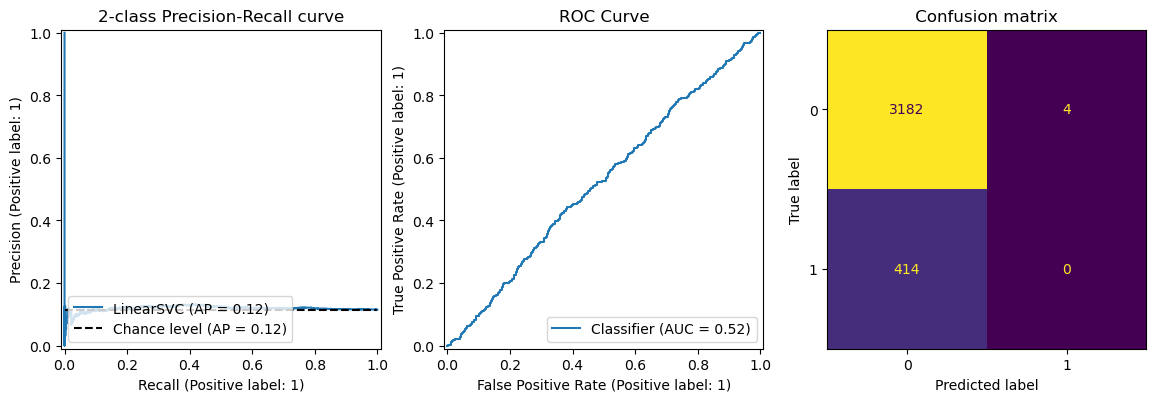

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(14, 8))

pr_display = PrecisionRecallDisplay.from_predictions(labels, logits, name="LinearSVC", plot_chance_level=True, ax=ax[0]);
_ = pr_display.ax_.set_title("2-class Precision-Recall curve");

roc_display = RocCurveDisplay.from_predictions(labels, logits, pos_label= 1, ax = ax[1])
_ = roc_display.ax_.set_title("ROC Curve")

cm_display = ConfusionMatrixDisplay.from_predictions(y_true = labels, y_pred =y_pred, ax = ax[2], colorbar = False)
_ = cm_display.ax_.set_title(" Confusion matrix ");

plt.show()


#### 

In [91]:
# test_accuracy = binary_accuracy(y_true=labels, y_prob=logits)
# test_f1 = binary_f1_score(y_true=labels, y_prob=logits)
# print(f"accuracy: {test_accuracy}%      F1 Score: {test_f1:.4f}")
# cm = confusion_matrix(y_true = labels, y_pred = (logits >= 0.5))
# disp = ConfusionMatrixDisplay(cm)
# disp.plot()


In [105]:
# filename = f"DNN-{args.model.lower()}-{args.seed}.json"
# export_results(model=model, filename=filename)

In [106]:
# for i in range(len(logits)):
#     if labels[i] == 1:
#         print(f" y_pred: {logits[i]:.5e}   {logits[i]>=0.500}  \t  y_true: {labels[i]}")

## Regression Metrics 

In [231]:
print(f" compute Regression metrics for epoch {epochs}")
R2_score   = skm.r2_score(y_true = y_true, y_pred = y_pred)
mse_score  = skm.mean_squared_error(y_true = y_true, y_pred = y_pred)
rmse_score = skm.root_mean_squared_error(y_true = y_true, y_pred = y_pred)
mae_score  = skm.mean_absolute_error(y_true = y_true, y_pred = y_pred)
# pearson_corr, pearson_p = sps.pearsonr(y_true, y_pred)

 compute Regression metrics for epoch 200


  #### Results

In [ ]:
 metrics as epoch 25     metrics as epoch 50     metrics as epoch 100   metrics as epoch 125   metrics as epoch 150  
---------------------- -----------------------  ---------------------- ---------------------- ---------------------- 
RMSE Score :  0.543655  RMSE Score :  0.539906   RMSE Score : 0.536459  RMSE Score : 0.624126  RMSE Score : 0.624126 
 MSE Score :  0.317944   MSE Score :  0.314051    MSE Score : 0.310318   MSE Score : 0.408070   MSE Score : 0.408070 
 MAE Score :  0.378762   MAE Score :  0.373654    MAE Score : 0.371468   MAE Score : 0.434099   MAE Score : 0.434099 
  R2 Score :  0.611225    R2 Score :  0.615898     R2 Score : 0.632036    R2 Score : 0.518840    R2 Score : 0.518840 

#### 25 epochs

In [195]:
print(f" metrics as epoch {epochs:^4d}")
print('-'*22)
print(f"RMSE Score : {rmse_score:.6f} ")
print(f" MSE Score : {mse_score:.6f} ")
print(f" MAE Score : {mae_score:.6f} ")
print(f"  R2 Score : {R2_score:.6f}  ")

 metrics as epoch  25 
----------------------
RMSE Score :  0.543655
 MSE Score :  0.317944
 MAE Score :  0.378762
  R2 Score :  0.611225


#### 50 epochs

In [186]:
print(f" metrics as epoch {epochs:^4d}")
print('-'*22)
print(f"RMSE Score : {rmse_score:.6f} ")
print(f" MSE Score : {mse_score:.6f} ")
print(f" MAE Score : {mae_score:.6f} ")
print(f"  R2 Score : {R2_score:.6f}  ")

 metrics as epoch 50
----------------------
RMSE Score :  0.539906
 MSE Score :  0.314051
 MAE Score :  0.373654
  R2 Score :  0.615898


#### 100 epochs

In [180]:
print(f" metrics as epoch {epochs:^4d}")
print('-'*22)
print(f"RMSE Score : {rmse_score:.6f} ")
print(f" MSE Score : {mse_score:.6f} ")
print(f" MAE Score : {mae_score:.6f} ")
print(f"  R2 Score : {R2_score:.6f}  ")

 metrics as epoch 100
----------------------
RMSE Score : 0.536459
 MSE Score : 0.310318
 MAE Score : 0.371468
  R2 Score : 0.632036


#### 125 epochs

In [217]:
print(f" metrics as epoch {epochs:^4d}")
print('-'*22)
print(f"RMSE Score : {rmse_score:.6f} ")
print(f" MSE Score : {mse_score:.6f} ")
print(f" MAE Score : {mae_score:.6f} ")
print(f"  R2 Score : {R2_score:.6f}  ")

 metrics as epoch 125 
----------------------
RMSE Score : 0.624126 
 MSE Score : 0.408070 
 MAE Score : 0.434099 
  R2 Score : 0.518840  


#### 150 epochs

In [224]:
print(f" metrics as epoch {epochs:^4d}")
print('-'*22)
print(f"RMSE Score : {rmse_score:.6f} ")
print(f" MSE Score : {mse_score:.6f} ")
print(f" MAE Score : {mae_score:.6f} ")
print(f"  R2 Score : {R2_score:.6f}  ")

 metrics as epoch 150 
----------------------
RMSE Score : 0.624126 
 MSE Score : 0.408070 
 MAE Score : 0.434099 
  R2 Score : 0.518840  


#### 175 epochs

In [228]:
print(f" metrics as epoch {epochs:^4d}")
print('-'*22)
print(f"RMSE Score : {rmse_score:.6f} ")
print(f" MSE Score : {mse_score:.6f} ")
print(f" MAE Score : {mae_score:.6f} ")
print(f"  R2 Score : {R2_score:.6f}  ")

 metrics as epoch 175 
----------------------
RMSE Score : 0.624126 
 MSE Score : 0.408070 
 MAE Score : 0.434099 
  R2 Score : 0.518840  


#### 200 epochs

In [232]:
print(f" metrics as epoch {epochs:^4d}")
print('-'*22)
print(f"RMSE Score : {rmse_score:.6f} ")
print(f" MSE Score : {mse_score:.6f} ")
print(f" MAE Score : {mae_score:.6f} ")
print(f"  R2 Score : {R2_score:.6f}  ")

 metrics as epoch 200 
----------------------
RMSE Score : 0.624126 
 MSE Score : 0.408070 
 MAE Score : 0.434099 
  R2 Score : 0.518840  


## Apply TSNe

In [83]:
tsne = TSNE(2)
projection = dict()

for k in range(6):
    projection[k] = tsne.fit_transform(embeddings[k])
    print(f" layer {k} projection shape: {projection[k].shape}")
    

 layer 0 projection shape: (3600, 2)
 layer 1 projection shape: (3600, 2)
 layer 2 projection shape: (3600, 2)
 layer 3 projection shape: (3600, 2)
 layer 4 projection shape: (3600, 2)
 layer 5 projection shape: (3600, 2)


# Plot TSNE embeddings

### 20 Epochs  

In [84]:
from snnl.utils import plot_TSNE

In [85]:
projection_subset = {0: projection[0],
                     1: projection[1],
                     2: projection[2], 
                     3: projection[3],
                     4: projection[4],
                     5: projection[5],                     
                    }

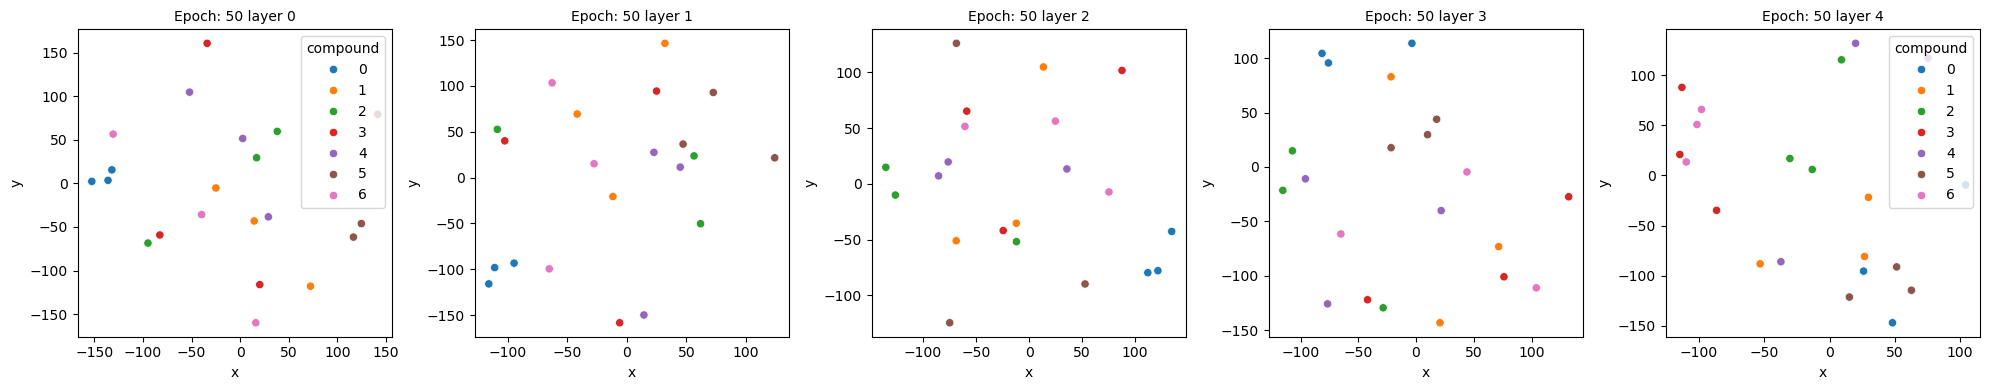

In [86]:
plot_TSNE(projection_subset,labels,comp_labels, key='compound', end = 21, epoch = last_epoch)

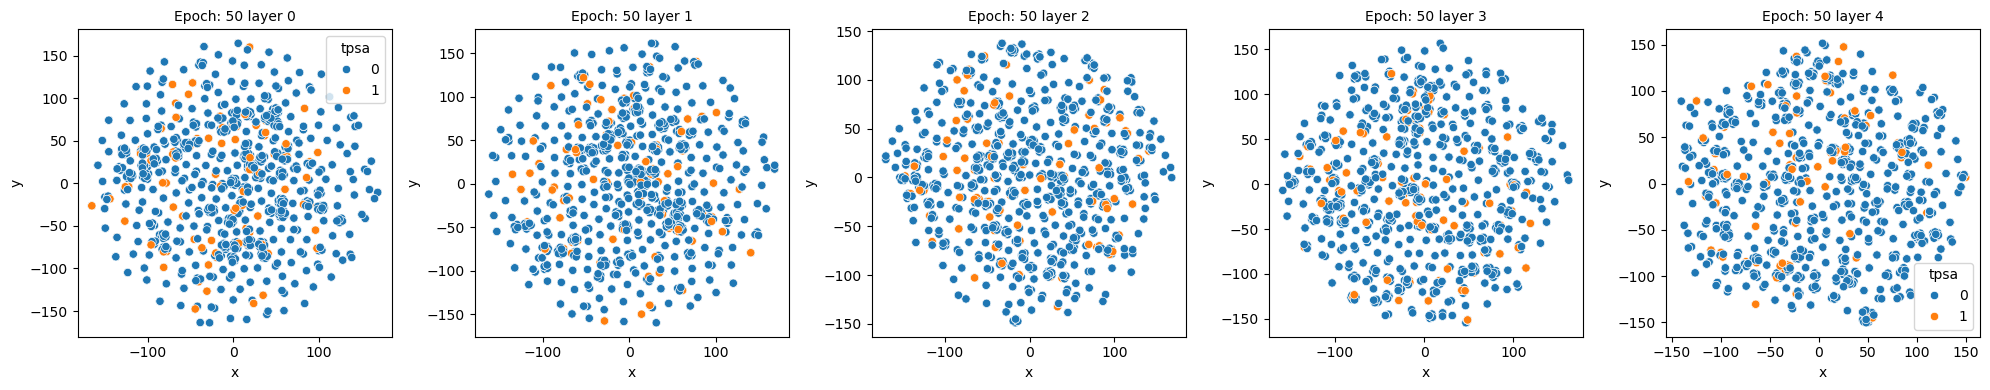

In [87]:
plot_TSNE(projection_subset,labels,comp_labels, key='tpsa', epoch = last_epoch)

### 40 Epochs  

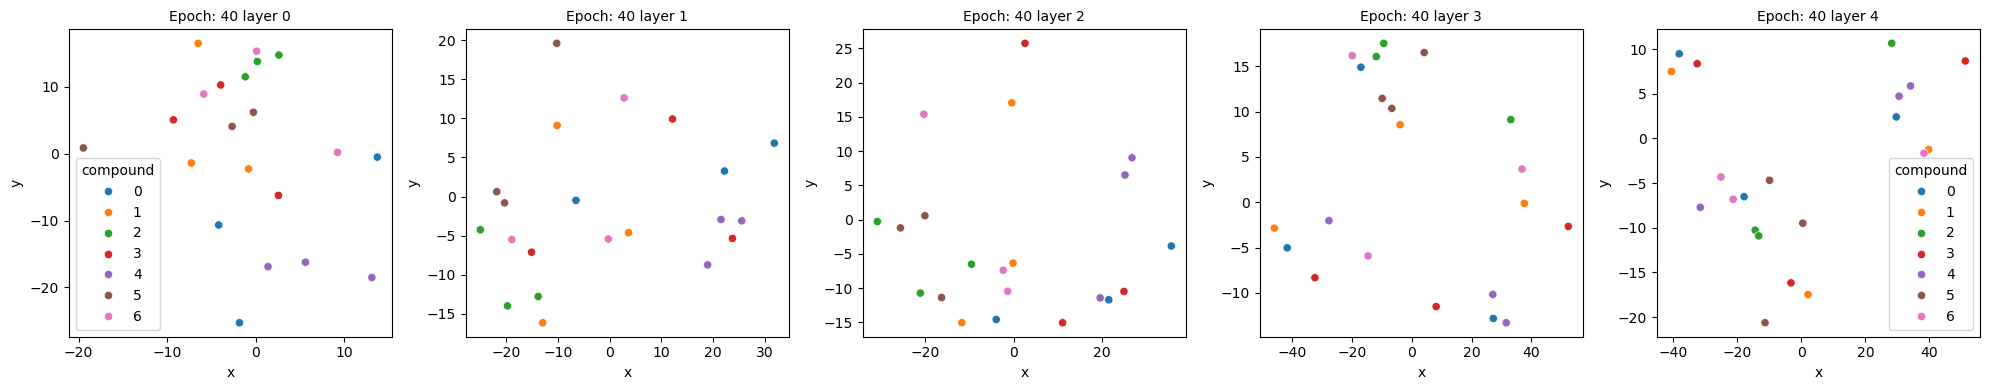

In [116]:
plot_TSNE(projection,labels,comp_labels, key='compound', end = 21, epoch = last_epoch)

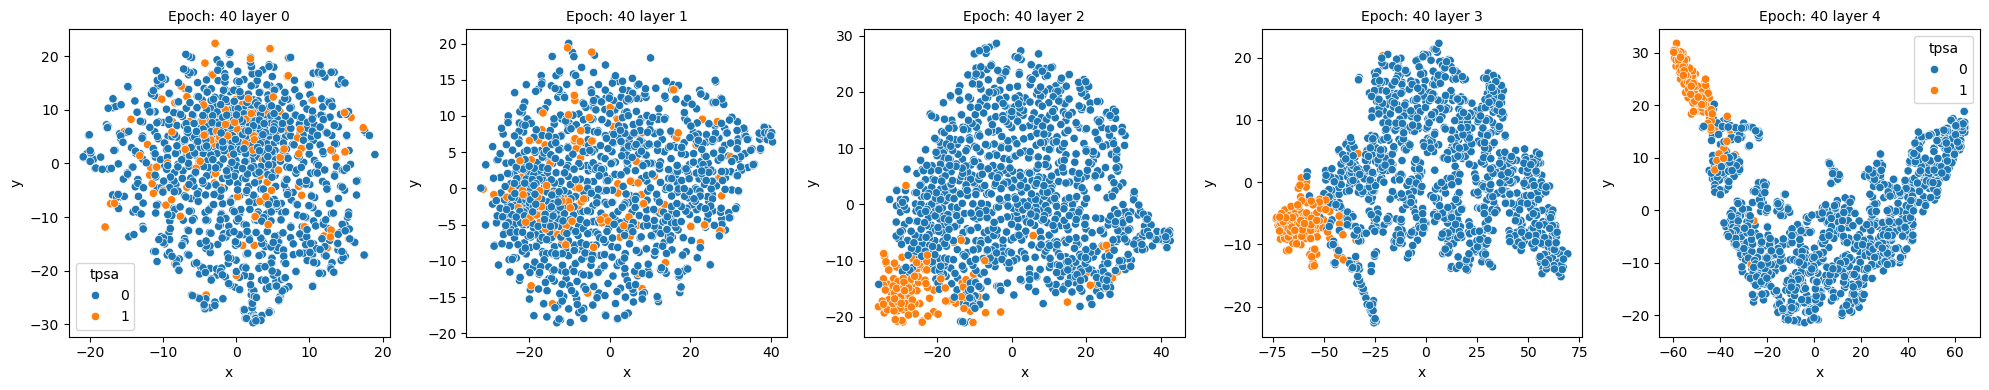

In [117]:
plot_TSNE(projection,labels,comp_labels, key='tpsa', epoch = last_epoch)

### 60 Epochs  

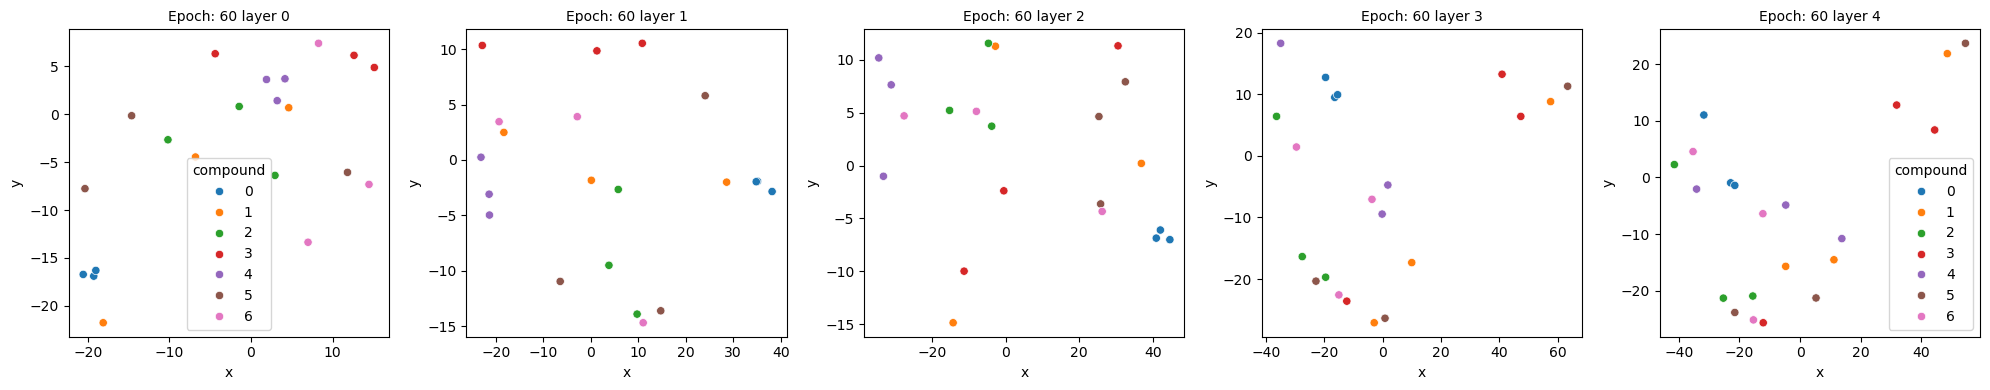

In [35]:
plot_TSNE(projection,labels,comp_labels, key='compound', end = 21, epoch = last_epoch)

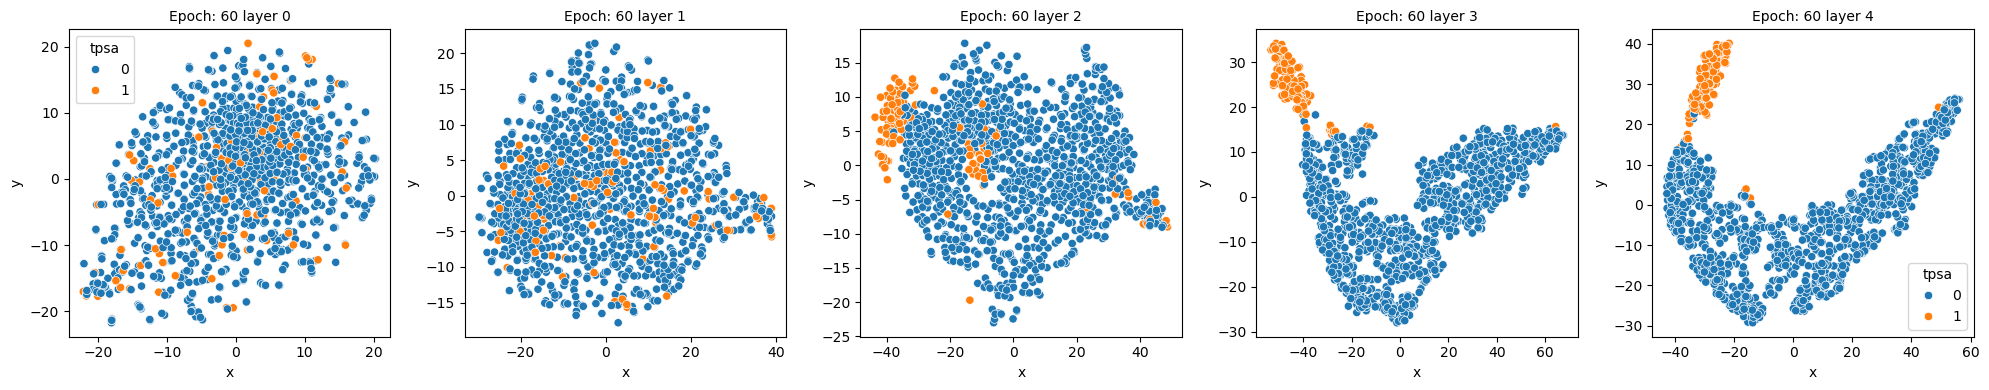

In [36]:
plot_TSNE(projection,labels,comp_labels, key='tpsa', epoch = last_epoch)

### 75 Epochs  

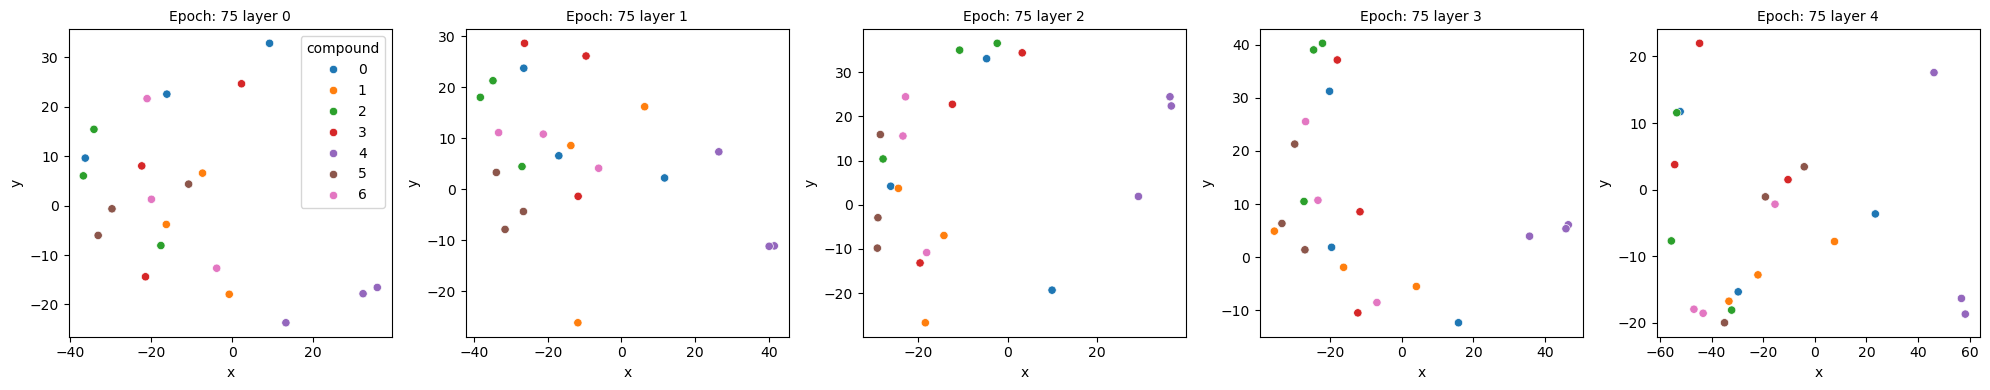

In [55]:
plot_TSNE(projection,labels,comp_labels, key='compound', end = 21, epoch = last_epoch)

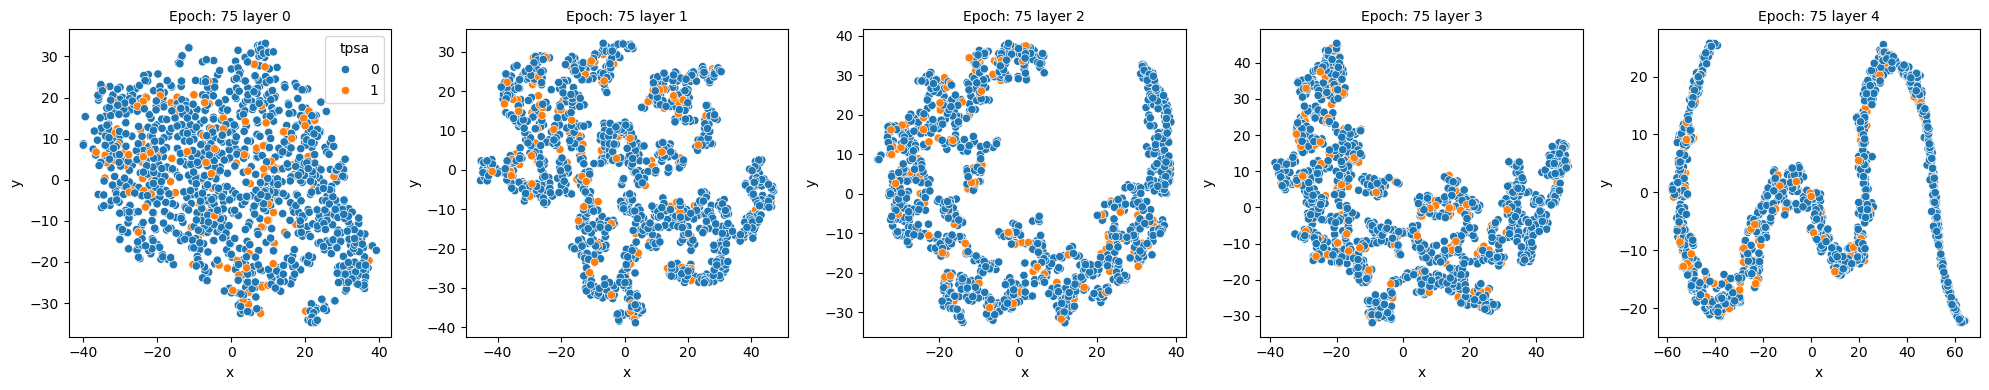

In [56]:
plot_TSNE(projection,labels,comp_labels, key='tpsa', epoch = last_epoch)

### 100 Epochs  

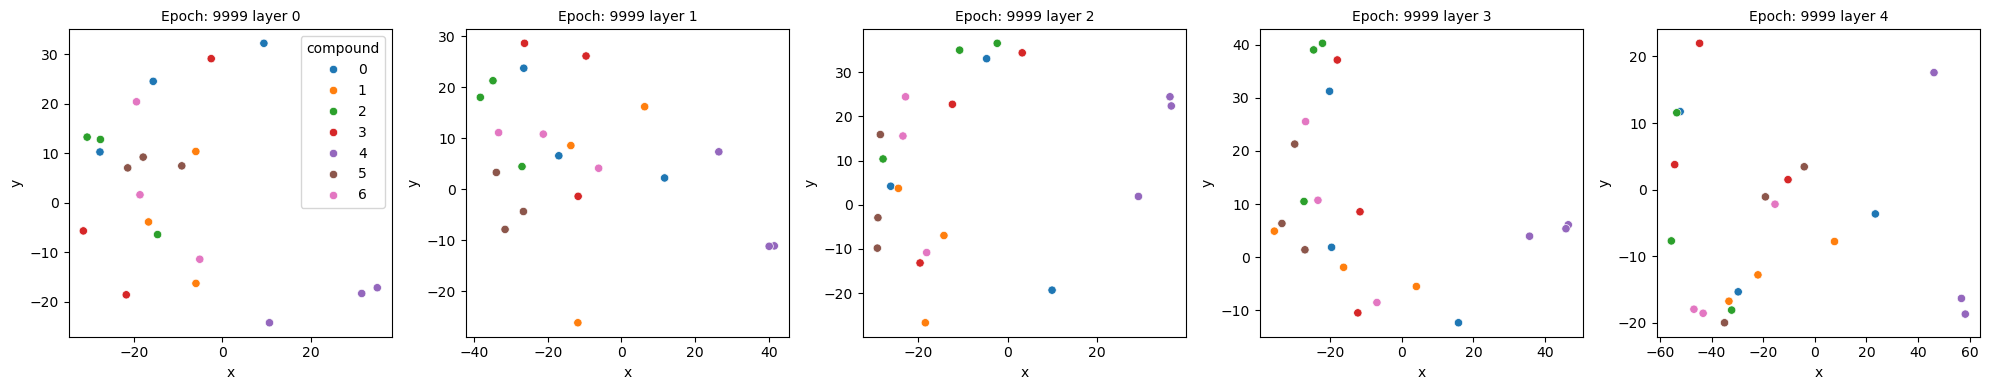

In [61]:
plot_TSNE(projection,labels,comp_labels, key='compound', end = 21, epoch = last_epoch)

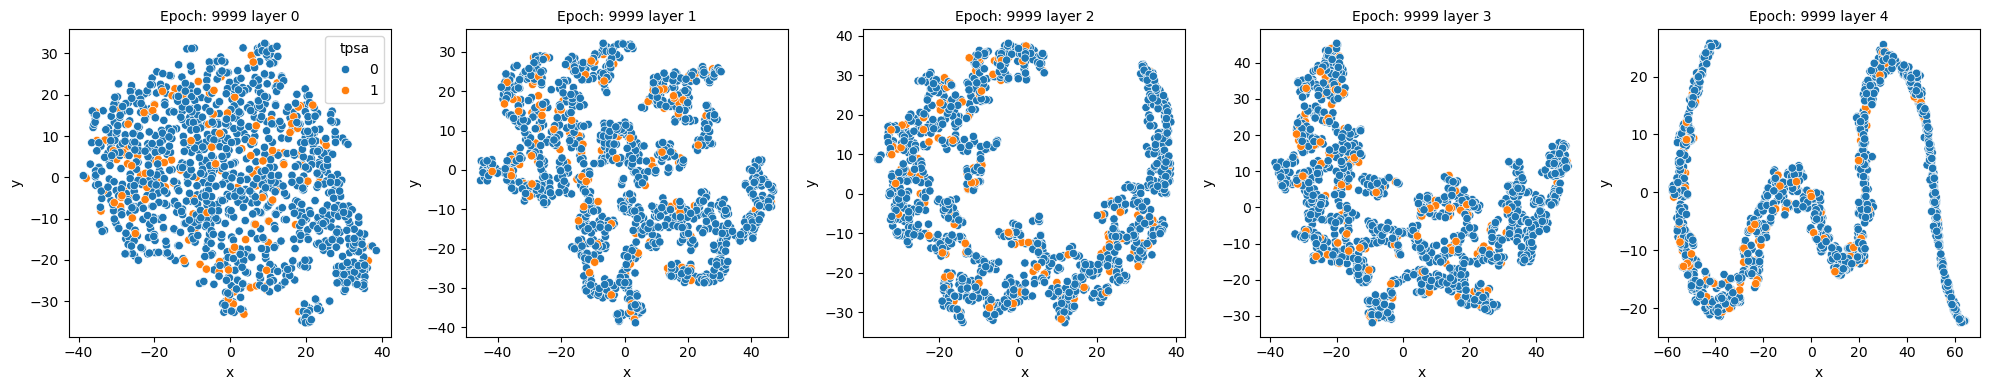

In [62]:
plot_TSNE(projection,labels,comp_labels, key='tpsa', epoch = last_epoch)

### 150 Epochs  

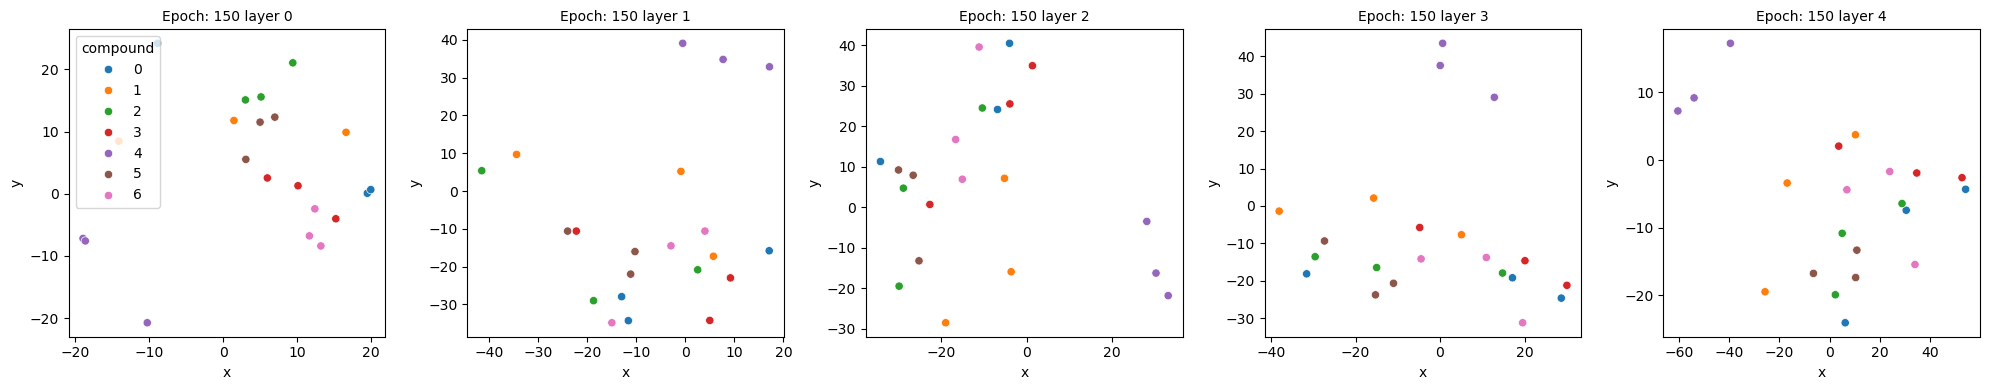

In [68]:
plot_TSNE(projection,labels,comp_labels, key='compound', end = 21, epoch = last_epoch)

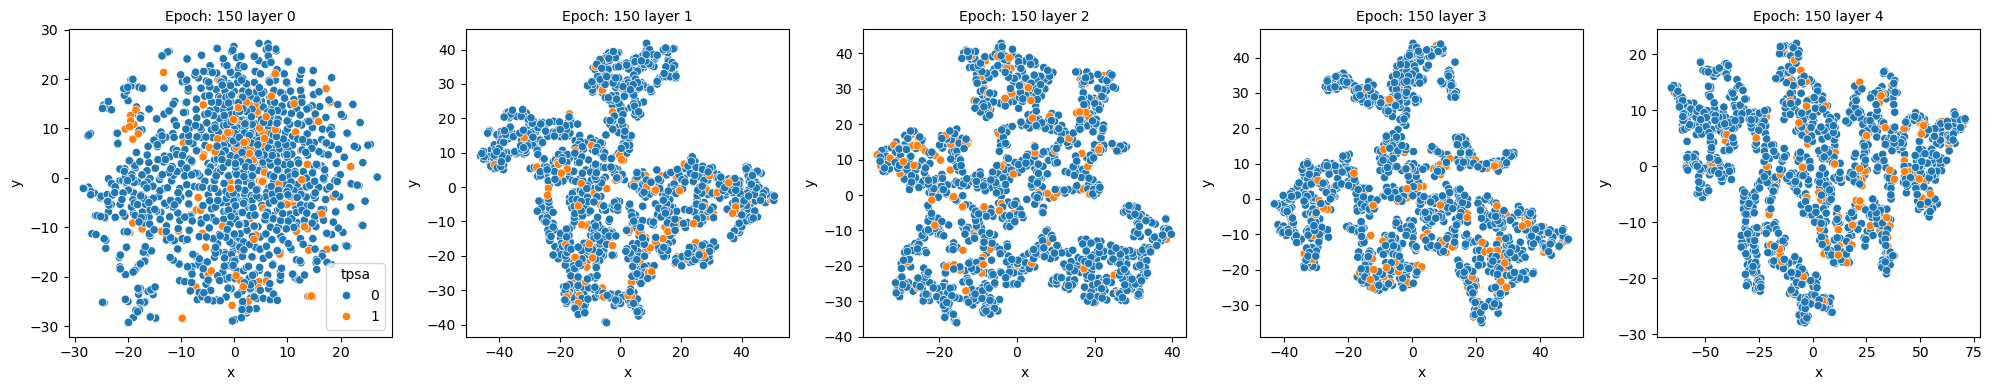

In [69]:
plot_TSNE(projection,labels,comp_labels, key='tpsa',  epoch = last_epoch)

### 175 Epochs  

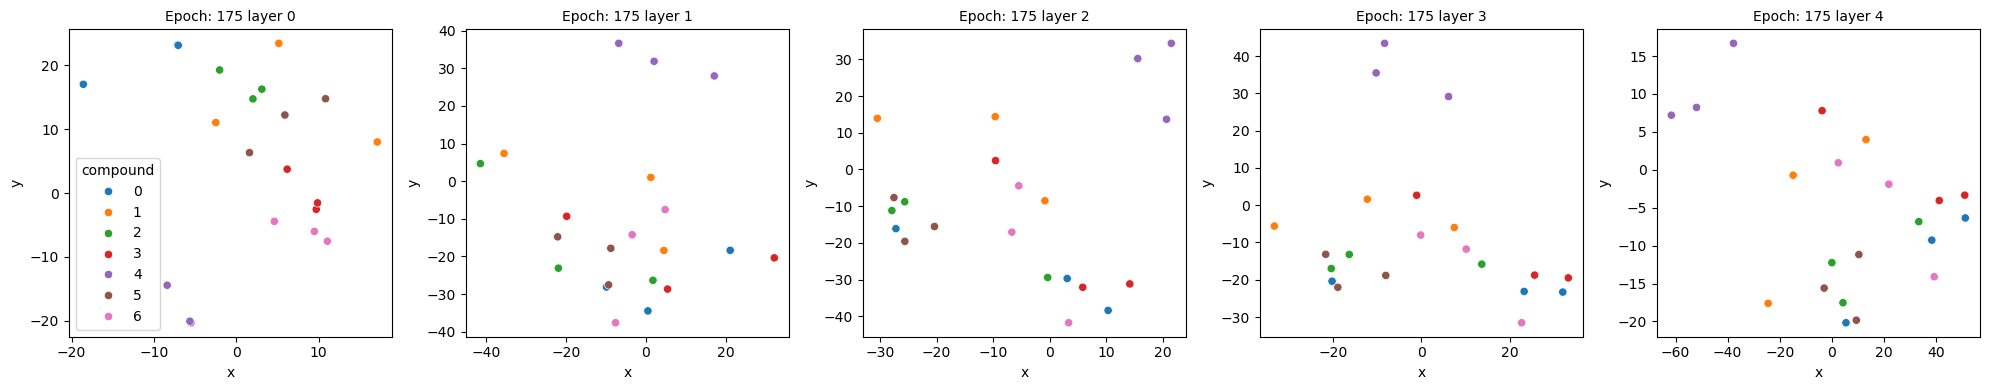

In [74]:
plot_TSNE(projection,labels,comp_labels, key='compound', end = 21, epoch = last_epoch)

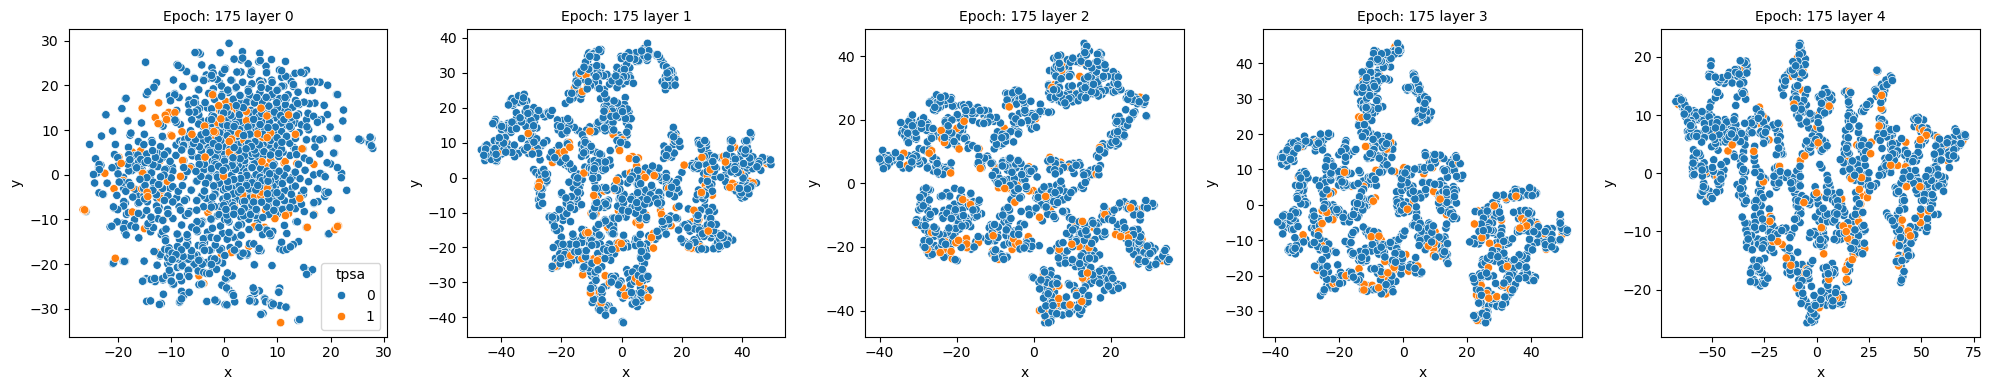

In [75]:
plot_TSNE(projection,labels,comp_labels, key='tpsa',  epoch = last_epoch)

### Based on Compound 

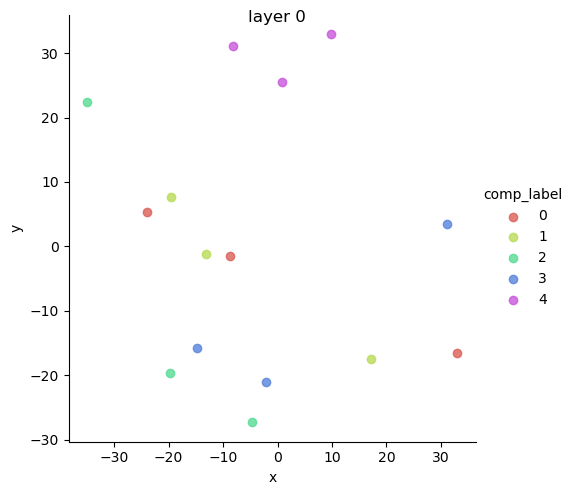

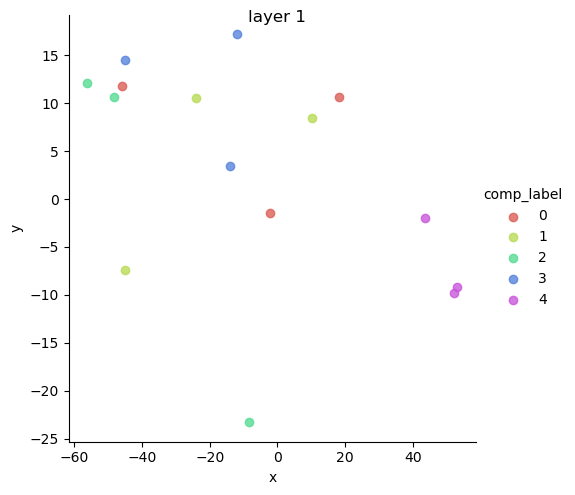

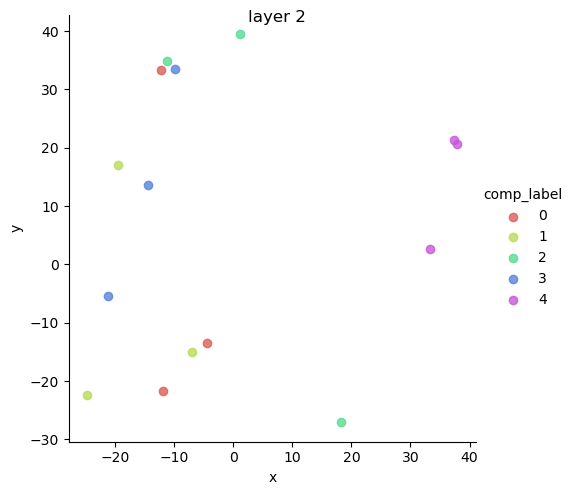

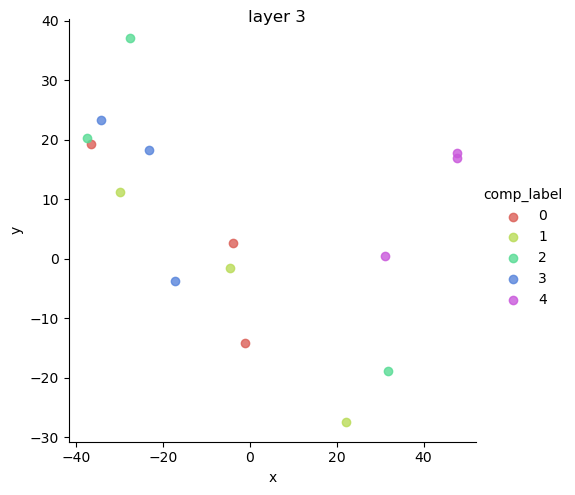

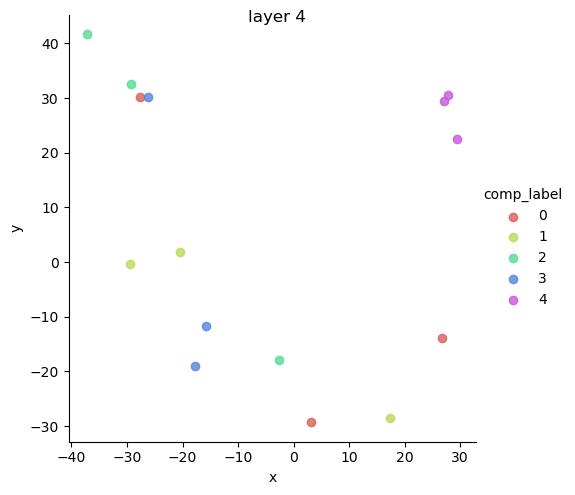

In [62]:
for layer in [0,1,2,3,4]:
    end = 15
    df = pd.DataFrame(dict(
        x=projection[layer][:end,0],
        y=projection[layer][:end,1],
        label=labels[0:end],
        comp_label = comp_labels[0:end]
    ))
    # _=plt.figure()
    lp=sb.lmplot( data=df, x ="x", y = "y", hue='comp_label', fit_reg=False, palette="hls") #, size=6)
    _=lp.fig.suptitle(f'layer {layer}')

plt.show()

### Based on TPSA Indicator 

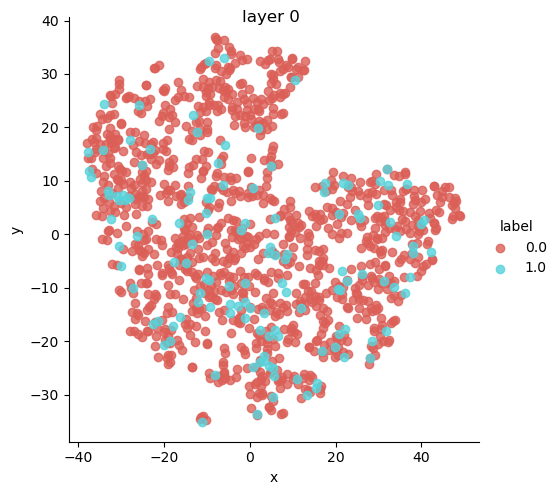

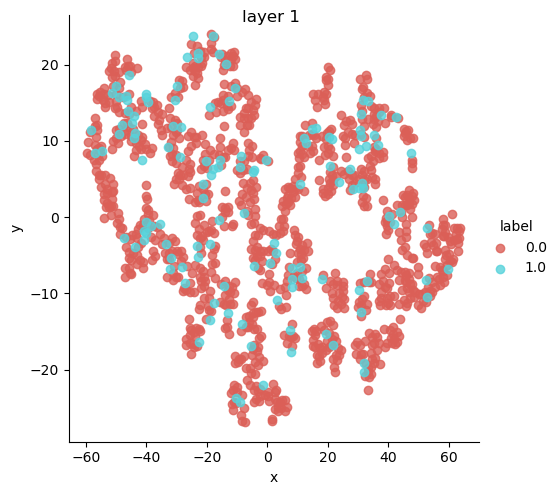

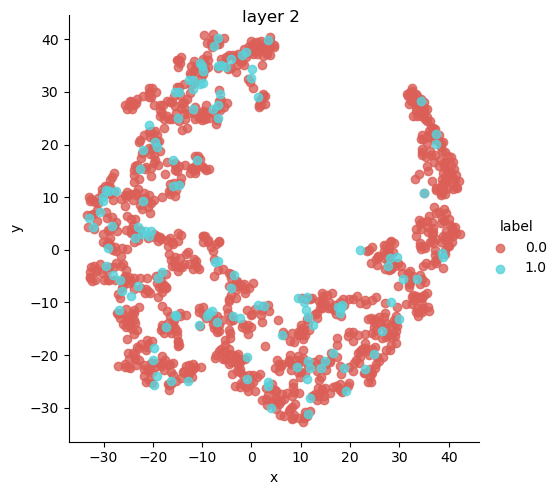

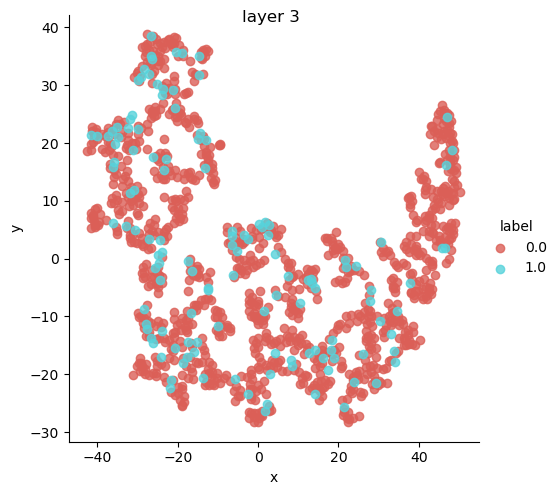

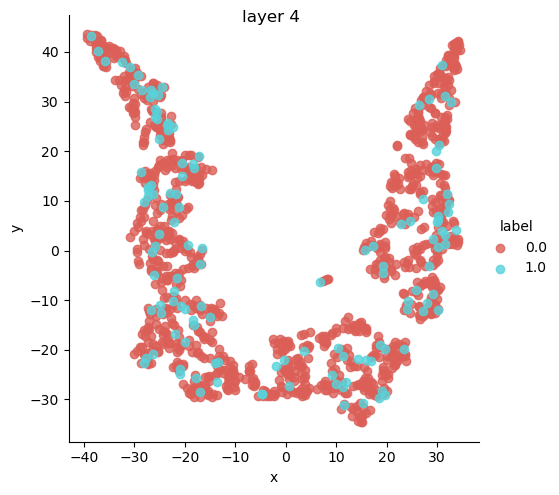

In [63]:
end = 1200
for layer in [0,1,2,3,4]:
    df = pd.DataFrame(dict(
        x=projection[layer][:end,0],
        y=projection[layer][:end,1],
        label=labels[0:end]
    ))
    lp= sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)
    _=lp.fig.suptitle(f'layer {layer}')
plt.show()

### Layer by Layer

#### Layer 1 

In [ ]:
layer= 1
end = 1200
df = pd.DataFrame(dict(
    x=projection[layer][:end,0],
    y=projection[layer][:end,1],
    # label=comp_label[0:end]
    label=labels[0:end]
))
df.shape
_=plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 2 

In [ ]:
layer= 2
end = 15
df = pd.DataFrame(dict(
    x=projection[layer][:end,0],
    y=projection[layer][:end,1],
    label=comp_label[0:end]
    # label=labels[0:end]
))
df.shape
_=plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 3 

In [ ]:
layer= 3
end = 15
df = pd.DataFrame(dict(
    x=projection[layer][:end,0],
    y=projection[layer][:end,1],
    label=comp_label[0:end]
    # label=labels[0:end]
))
df.shape
_=plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 4 

In [ ]:
layer= 4
end = 15
df = pd.DataFrame(dict(
    x=projection[layer][:end,0],
    y=projection[layer][:end,1],
    label=comp_label[0:end]
    # label=labels[0:end]
))
df.shape
_=plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls" ) #, size=6)

In [ ]:
np.bincount(labels.astype(np.int64))

In [ ]:
from matplotlib import cm
x=projection[4][:,0]
y=projection[4][:,1]
# z=projection[4][:,2]
label=np.expand_dims(labels,-1)
z = np.expand_dims(z,-1)
z.shape

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
# Plot the 3D surface
# ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
# ax.plot_trisurf(x, y, z, linewidth=0 , )
# surf = ax.plot_surface(x, y, label, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(x, y, label)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
ax.view_init(elev=45.)

plt.show()

# PCA and TSNE

## define PCA model

In [ ]:
loader_iter = iter(train_loader)

In [ ]:
(batch_features, batch_labels, batch_plates, batch_compounds, batch_hash) = next(loader_iter)

In [ ]:
type(batch_features), batch_features.shape, batch_labels.numpy().shape

In [ ]:
pca = PCA(n_components=200, copy=False, whiten=False, 
          svd_solver='auto', tol=0.0, iterated_power='auto', 
          n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

In [ ]:
pca.fit(batch_features)
X = pca.transform(batch_features)

## define TSNE 

In [ ]:
tsne = TSNE()

projection = tsne.fit_transform(X)

projection.shape

In [ ]:
rows = 1000
df = pd.DataFrame(dict(
    x=projection[:rows,0],
    y=projection[:rows,1],
    label=batch_labels.numpy()[:rows]
    # moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    # batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    # compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    # correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    # level=pd.concat([treated_wells["level"],treatments["level"]])
))

df.info()
df.head()

In [ ]:
plt.figure()
# sb.lmplot('x', 'y', data=df, hue='label', fit_reg=False, palette="hls", size=6)
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)


## Apply TSNE on embeddings

In [ ]:
tsne = TSNE(2)
projection = dict()
for k,v in embeddings.items():
    projection[k] = tsne.fit_transform(v)
    projection[k].shape

#### Layer 0 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[0][:,0],
    y=projection[0][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 1 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[1][:,0],
    y=projection[1][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 2 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[2][:,0],
    y=projection[2][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 3 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[3][:,0],
    y=projection[3][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 4 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[4][:,0],
    y=projection[4][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

In [ ]:
np.bincount(labels.astype(np.int64))

In [ ]:
from matplotlib import cm
x=projection[4][:,0]
y=projection[4][:,1]
# z=projection[4][:,2]
label=np.expand_dims(labels,-1)
z = np.expand_dims(z,-1)
z.shape

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
# Plot the 3D surface
# ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
# ax.plot_trisurf(x, y, z, linewidth=0 , )
# surf = ax.plot_surface(x, y, label, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(x, y, label)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
ax.view_init(elev=45.)

plt.show()